## Notice

This notebook is no longer being used, but kept for reference. It contains code for running a XGB for next-day close price prediction using 90+ technical indicators, and managed to provide 11% annual returns with low drawdown. However, it was scrapped due to lack of time in putting it into the presentation materials.

In [37]:
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
tickers = pd.read_csv("../data/processed/starting_portfolio_2months.csv")['asset'].to_list()
weights = pd.read_csv("../data/processed/starting_portfolio_2months.csv").set_index('asset')

In [38]:
# Commission fee based on Webull, which is known for low commission fees:
# https://www.webull.com.sg/pricing
# Regular and Extended Hours (04:00 - 20:00 EST)
# 0.025%*Total Trade Amount (Min. USD 0.50)

def commission(order_size, price):
    return max(0.5, abs(order_size) * price * 0.00025)

In [39]:
import yfinance as yf
import tqdm
import pickle as pkl

start_date = "2024-03-01"
end_date = "2025-03-01" # Last day is exclusive
true_start_date = "2025-01-01"

portfolio = {}
for asset in tqdm.tqdm(tickers):
    portfolio[asset] = {
        "data": yf.Ticker(asset).history(start=start_date, end=end_date, actions=False),
    }
    
portfolio


100%|██████████| 30/30 [00:00<00:00, 115.39it/s]


{'AES': {'data':                                 Open       High        Low      Close  \
  Date                                                                    
  2024-03-01 00:00:00-05:00  14.519653  14.815777  14.175766  14.777568   
  2024-03-04 00:00:00-05:00  14.787121  15.513104  14.739360  15.350713   
  2024-03-05 00:00:00-05:00  15.379369  16.411029  15.302950  15.427131   
  2024-03-06 00:00:00-05:00  15.866542  15.971617  15.369816  15.493997   
  2024-03-07 00:00:00-05:00  15.761466  15.790123  15.427131  15.436684   
  ...                              ...        ...        ...        ...   
  2025-02-24 00:00:00-05:00  10.570000  10.730000  10.360000  10.720000   
  2025-02-25 00:00:00-05:00  10.720000  10.970000  10.600000  10.860000   
  2025-02-26 00:00:00-05:00  10.950000  11.040000  10.700000  10.920000   
  2025-02-27 00:00:00-05:00  10.970000  10.970000  10.380000  10.380000   
  2025-02-28 00:00:00-05:00  11.050000  12.000000  10.750000  11.590000   
  
       

In [40]:
import pandas_ta as ta


def calculate_technical_indicators(df):
    """
    We calculate all the technical indicators required for all the strategies first
    before truncating the data. This is so that we have data on e.g. 50-day moving
    averages even on our desired day 1, but we only run backtesting from day 1 onwards.
    """

    # Core indicators
    df["EMA_50"] = ta.ema(df["Close"], length=50)
    df["EMA_200"] = ta.ema(df["Close"], length=200)
    df["RSI"] = ta.rsi(df["Close"], length=14)
    df["ATR"] = ta.atr(df["High"], df["Low"], df["Close"], length=7)

    # Bollinger Bands of length 20
    bbands = ta.bbands(df["Close"], length=20)
    bbands = bbands.rename(
        columns={
            "BBU_20_2.0": "Upper_Band",
            "BBM_20_2.0": "Middle_Band",
            "BBL_20_2.0": "Lower_Band",
            "BBB_20_2.0": "Band_Width",
            "BBP_20_2.0": "Percent_B",
        }
    )

    # Bollinger Bands of length 200
    bbands200 = ta.bbands(df["Close"], length=200)
    bbands200 = bbands200.rename(
        columns={
            "BBU_200_2.0": "Upper_Band_200",
            "BBM_200_2.0": "Middle_Band_200",
            "BBL_200_2.0": "Lower_Band_200",
            "BBB_200_2.0": "Band_Width_200",
            "BBP_200_2.0": "Percent_B_200",
        }
    )

    # MACD
    macd = ta.macd(df["Close"])
    macd = macd.rename(
        columns={
            "MACD_12_26_9": "MACD",
            "MACDh_12_26_9": "Histogram",
            "MACDs_12_26_9": "Signal",
        }
    )

    # Miscellaneous
    df["SMA_20"] = ta.sma(df["Close"], length=20)
    df["STD_20"] = ta.stdev(df["Close"], length=20)
    df["SMA_Volume_10"] = ta.sma(df["Volume"], length=10)
    df["Momentum"] = ta.mom(df["Close"], length=10)

    df = df.join([bbands, bbands200, macd])

    return df

In [41]:
from backtesting import Backtest
asset = 'CBRE'

from strategies.backtest.mean_reversion import MeanReversion

import warnings
warnings.filterwarnings("ignore")

data = portfolio[asset]["data"]
data = calculate_technical_indicators(portfolio[asset]["data"])
data.index = data.index.values.astype("datetime64[D]")
bt = Backtest(
    data, MeanReversion, 
    cash=1000000, commission=commission, finalize_trades=True
)
run_stats = bt.run().to_dict()
stats = {'asset': asset, '_strategy': 'Unknown'}
stats.update(run_stats)

bt.plot()

GridPlot(id='p2389', ...)

In [32]:
stats['Return (Ann.) [%]']

-10.616034437233923

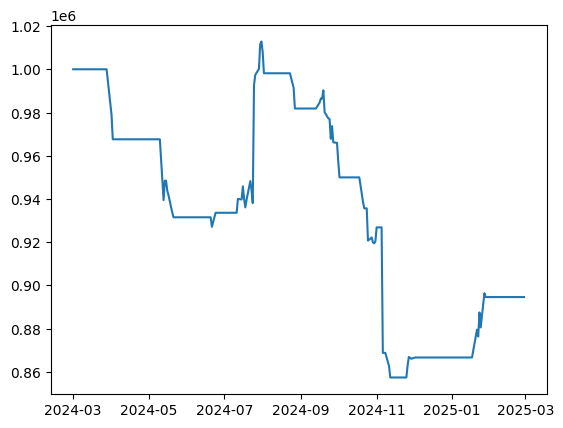

In [33]:
#plot stats['_equity_curve']

import matplotlib.pyplot as plt
plt.plot(stats['_equity_curve']['Equity'])
plt.show()


In [34]:
stats['_equity_curve'][stats['_equity_curve']['Equity'] > 1.000000e+06]


,Equity,DrawdownPct,DrawdownDuration
2024-07-29,1.000233e+06,0.000000,123 days
2024-07-30,1.011587e+06,0.000000,NaT
2024-07-31,1.012863e+06,0.000000,NaT
2024-08-01,1.008057e+06,0.004746,NaT


In [35]:
stats['_trades']


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,ReturnPct,EntryTime,ExitTime,Duration,Tag
0,10255,20,21,97.010002,93.900002,92.377998,106.963998,-31893.056259,-0.032059,2024-04-01,2024-04-02,1 days,None
1,10602,50,51,90.760002,89.000000,85.709001,99.242001,-18659.542648,-0.019392,2024-05-13,2024-05-14,1 days,None
2,10199,53,54,92.489998,91.870003,87.647002,101.486002,-6323.330200,-0.006703,2024-05-16,2024-05-17,1 days,None
3,10298,55,56,90.940002,90.000000,86.706497,100.396996,-9680.145142,-0.010337,2024-05-20,2024-05-21,1 days,None
4,10204,77,78,90.790001,91.040001,85.671000,99.198000,2551.000000,0.002754,2024-06-21,2024-06-24,3 days,None
5,9881,91,92,93.980003,94.650002,88.464003,102.432003,6620.251907,0.007129,2024-07-12,2024-07-15,3 days,None
6,9680,93,94,96.580002,96.660004,91.057499,105.434998,774.417725,0.000828,2024-07-16,2024-07-17,1 days,None
7,9594,95,96,97.480003,97.480003,93.023998,107.711998,0.000000,0.000000,2024-07-18,2024-07-19,1 days,None
8,9554,97,98,97.839996,98.360001,92.938502,107.613002,4968.120819,0.005315,2024-07-22,2024-07-23,1 days,None
9,9497,99,100,98.910004,104.070000,94.202003,109.076004,49004.482323,0.052169,2024-07-24,2024-07-25,1 days,None


In [36]:
all_stats = {}
for asset in tickers:
    import warnings
    warnings.filterwarnings("ignore")

    data = portfolio[asset]["data"]
    data.index = data.index.values.astype("datetime64[D]")
    bt = Backtest(
        data, XGBFactory.get(f"../data/processed/xgb/{asset}.json", 1, 1), 
        cash=1e6 * weights.loc[asset, 'weight'], commission=commission, finalize_trades=True
    )
    run_stats = bt.run().to_dict()
    stats = {'asset': asset, '_strategy': 'Unknown'}
    stats.update(run_stats)

    all_stats[asset] = stats


NameError: name 'XGBFactory' is not defined

In [49]:
(sum(stats['Equity Final [$]'] for stats in all_stats.values()) / 1e6) ** 12

1.110979388117692